In [1]:
import shap
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import math
# import eli5

In [2]:
#pip install "shap"

In [3]:
# Read data
# IndicesPd = pd.read_excel("File_5_-_IoD2019_ScoresM.xlsx", sheet_name="IoD2019 Scores", header= 0)

In [4]:
IndicesPd=pd.read_csv("File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv")

In [5]:
IndicesPd.columns

Index(['LSOA code (2011)', 'LSOA name (2011)',
       'Local Authority District code (2019)',
       'Local Authority District name (2019)',
       'Index of Multiple Deprivation (IMD) Score',
       'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)',
       'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
       'Income Score (rate)', 'Income Rank (where 1 is most deprived)',
       'Income Decile (where 1 is most deprived 10% of LSOAs)',
       'Employment Score (rate)', 'Employment Rank (where 1 is most deprived)',
       'Employment Decile (where 1 is most deprived 10% of LSOAs)',
       'Education, Skills and Training Score',
       'Education, Skills and Training Rank (where 1 is most deprived)',
       'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)',
       'Health Deprivation and Disability Score',
       'Health Deprivation and Disability Rank (where 1 is most deprived)',
       'Health Dep

In [6]:
X=pd.DataFrame()
X['income_scores'] =IndicesPd['Income Score (rate)']
X['income_rank'] =  32845-IndicesPd['Income Rank (where 1 is most deprived)']
X['employment_scores'] = IndicesPd['Employment Score (rate)']
X['employment_rank'] =  32845-IndicesPd['Employment Rank (where 1 is most deprived)']
X['edu_scores'] = IndicesPd['Education, Skills and Training Score']
X['edu_rank'] =  32845-IndicesPd['Education, Skills and Training Rank (where 1 is most deprived)']
X['health_scores'] = IndicesPd['Health Deprivation and Disability Score']
X['health_rank'] =  32845-IndicesPd['Health Deprivation and Disability Rank (where 1 is most deprived)']
X['crime_scores'] = IndicesPd['Crime Score']
X['crime_rank'] =  32845-IndicesPd['Crime Rank (where 1 is most deprived)']
X['house_scores'] = IndicesPd['Barriers to Housing and Services Score']
X['house_rank'] =  32845-IndicesPd['Barriers to Housing and Services Rank (where 1 is most deprived)']
X['live_scores']=IndicesPd['Living Environment Score']
X['live_rank']= 32845-IndicesPd['Living Environment Rank (where 1 is most deprived)']
X

,income_scores,income_rank,employment_scores,employment_rank,edu_scores,edu_rank,health_scores,health_rank,crime_scores,crime_rank,house_scores,house_rank,live_scores,live_rank
0,0.007,14,0.010,103,0.024,3,-1.654,732,-2.012,183,29.472,25526,31.873,25056
1,0.034,2944,0.027,1655,0.063,13,-1.115,3140,-2.343,56,24.412,21138,23.084,19775
2,0.086,14335,0.086,17742,5.804,6459,-0.102,15245,-1.032,3482,40.103,30688,40.535,28753
3,0.211,26816,0.136,25012,22.260,20475,-0.121,14938,-1.317,1786,39.900,30628,28.979,23448
4,0.117,18822,0.059,11153,14.798,15334,-0.359,11264,-0.147,13997,45.171,31812,26.888,22216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32839,0.470,32755,0.341,32669,73.723,32280,2.361,32732,1.316,31157,16.867,12247,20.426,17892
32840,0.362,32007,0.280,32145,59.571,31064,1.665,31903,1.015,29443,19.411,15466,12.584,11414
32841,0.099,16415,0.073,14841,11.133,12074,0.823,27151,0.054,17013,4.477,617,58.942,32067
32842,0.396,32403,0.291,32295,64.836,31637,1.828,32246,0.314,21117,11.968,6248,57.424,31930


In [7]:
#根据domain中每个score对应的真实rank，小范围更改score的值使其能通过直接对score排序得到真实rank值
for i in range(0, 14, 2):
    scores=X.columns[i]
    ranks=X.columns[i+1]
    X.sort_values(by = ranks, inplace=True)#目的是为了最后一行代码那能直接按顺序加1e-6
    part_df=X.iloc[:,[i, i+1]]#每两列一取：一个domain下的scores列和ranks列
    part_df_count=part_df[scores].value_counts()
    #print("part_df_count.head(1)") #看看每个domain下面重复最多的值有多少个，最大280多个，所以取1e-6
    for score in part_df_count.index:#当发现重复的值只有一个的时候，跳出循环
        if part_df_count[score]==1:
            break
        else:
            score_df=part_df[part_df[scores]==score][scores]
            index=score_df.index#取出这些重复值对应的index
            X.loc[index, scores]=[num + i * 1e-6 for i, num in enumerate(score_df)]

In [8]:
#从list中筛选
#a = [i for i in X.columns.to_list() if i[-6:]=="scores"] #方法1
# def f(index):                    #方法2
#     return index[-6:]=="scores"
# a = set(filter(f,X.columns))
# a = set(filter(lambda x: x[-6:]=="scores", X.columns.to_list())) #方法3
# X.loc[:,a]

In [9]:
 X1 = X.filter(regex="scores$",axis=1).copy(deep=True)

In [48]:
X1=X1.sort_index()
X1

,income_scores,employment_scores,edu_scores,health_scores,crime_scores,house_scores,live_scores
0,0.007001,0.010024,0.024000,-1.654000,-2.012000,29.472001,31.873000
1,0.034210,0.027173,0.063001,-1.115000,-2.343000,24.412001,23.084000
2,0.086112,0.086043,5.804001,-0.101991,-1.031999,40.103000,40.535000
3,0.211025,0.136091,22.260000,-0.120989,-1.317000,39.900000,28.979001
4,0.117109,0.059257,14.798000,-0.358994,-0.146999,45.171000,26.888001
...,...,...,...,...,...,...,...
32839,0.470001,0.341000,73.723000,2.361001,1.316003,16.867000,20.426000
32840,0.362009,0.280001,59.571000,1.665001,1.015004,19.411001,12.584000
32841,0.099116,0.073121,11.133000,0.823010,0.054005,4.477000,58.942000
32842,0.396001,0.291009,64.836000,1.828000,0.314012,11.968002,57.424000


In [99]:
from sortedcontainers import SortedList
lol=[]
for i in range(7):
    l = SortedList()
    l.update(X1.iloc[:,i])
    lol.append(l)
lol[0].index(0.003)

0

In [102]:
#The function  that transform 7 domain scores to IMD score

def transform_old(rows):
    IMDs=[]
    for row in rows:
        rankRow=[]
        for i in range(len(row)):    
            index = abs(X1.iloc[:, i]-row[i]).sort_values().index[0]
            rank=X1.rank().loc[index, X1.columns[i]]
            rankRow.append(rank)
        rankRow=np.array(rankRow)
#         print(rankRow)
        x=-23*np.log((1-rankRow/32844*(1-math.exp(-100/23))))
        IMD = np.dot(np.array([0.225,0.225,0.135,0.135,0.093,0.093,0.093]),np.array(x).T)
        IMDs.append(IMD)
    IMDs= np.array(IMDs)
        # IMD = pd.DataFrame({"IMD":np.dot(np.array([0.225,0.225,0.135,0.135,0.093,0.093,0.093]),np.array(x).T)})
    return IMDs

In [118]:
#NNNew!!!
#The function  that transform 7 domain scores to IMD score

def transform(rows):
    IMDs=[]
    for row in rows:
        rankRow=[]
        for i in range(len(row)):    
            lol[i].add(row[i])
            rankRow.append(lol[i].index(row[i])+ 1)
            lol[i].remove(row[i])
        rankRow=np.array(rankRow)
       # print(rankRow)
        x=-23*np.log((1-rankRow/32844*(1-math.exp(-100/23))))
        IMD = np.dot(np.array([0.225,0.225,0.135,0.135,0.093,0.093,0.093]),np.array(x).T)
        IMDs.append(IMD)
    IMDs= np.array(IMDs)
        # IMD = pd.DataFrame({"IMD":np.dot(np.array([0.225,0.225,0.135,0.135,0.093,0.093,0.093]),np.array(x).T)})
    return IMDs

In [110]:
IMD = transform(X1.values[1].reshape(1,-1))
IMD


[ 2944  1655    13  3140    56 21138 19775]


array([5.14303756])

In [112]:
y = IndicesPd["Index of Multiple Deprivation (IMD) Score"]
y.values[1]-IMD


array([-3.75646897e-05])

In [113]:
reference=X1.mean().T.values.reshape(1,-1)

In [114]:
X1.values[0:3]

array([[ 7.0010000e-03,  1.0024000e-02,  2.4000000e-02, -1.6540000e+00,
        -2.0120000e+00,  2.9472001e+01,  3.1873000e+01],
       [ 3.4210000e-02,  2.7173000e-02,  6.3001000e-02, -1.1150000e+00,
        -2.3430000e+00,  2.4412001e+01,  2.3084000e+01],
       [ 8.6112000e-02,  8.6043000e-02,  5.8040010e+00, -1.0199100e-01,
        -1.0319990e+00,  4.0103000e+01,  4.0535000e+01]])

In [132]:
import shap
# reference = list(X1.mean().values)
explainer = shap.KernelExplainer(transform, reference)
shap_values = explainer.shap_values(X1.values)

# print("shap_values =", shap_values)
print("base value =", explainer.expected_value)


base value = 19.61789603022021


In [124]:
# visualize the first row's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X1.iloc[0,:])

In [144]:
# visualize 
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X1.iloc[:1000,:])

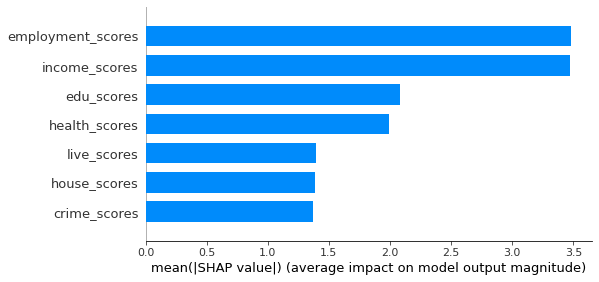

In [137]:
shap.summary_plot(shap_values, X1, plot_type="bar")

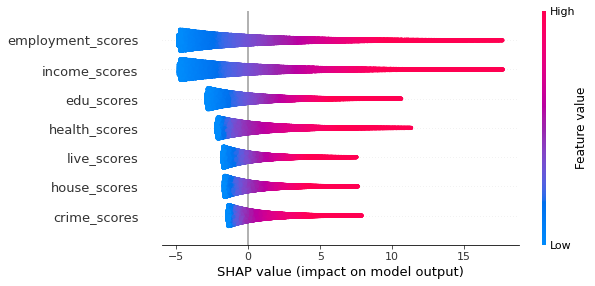

In [138]:
shap.summary_plot(shap_values, X1)

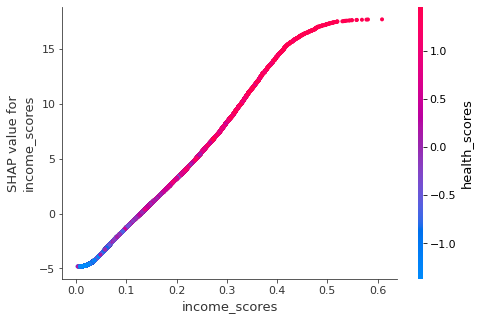

In [139]:
shap.dependence_plot('income_scores', shap_values, X1)